In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import ttest_ind
from matplotlib import pyplot
import sys
from IPython import display

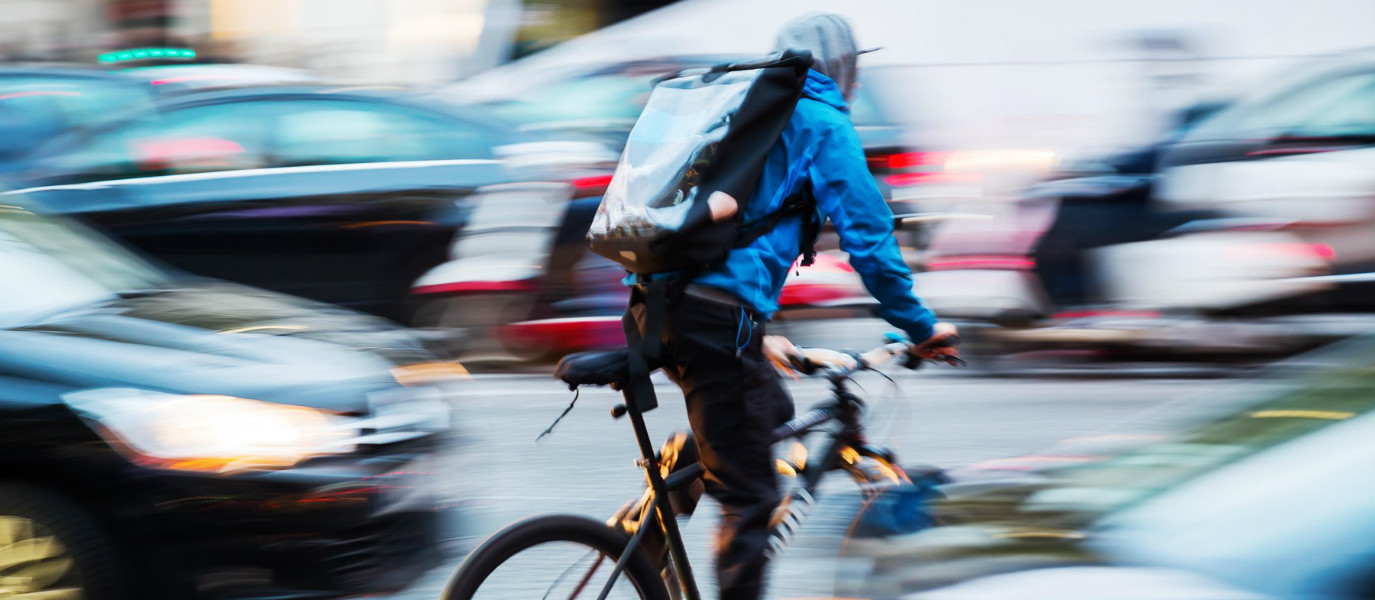

In [3]:
display.Image("https://d2p6e6u75xmxt8.cloudfront.net/2/2017/02/331313_1331331.jpg")

In [4]:
pd.options.mode.chained_assignment= None
pd.set_option('display.max_columns', None)
path = sys.path[0]

In [5]:
d=pd.read_csv(path+'/Work - Foglio1.csv')
d.head()

,date,schedule,etips,cash,deliveries,km,hrs,earnings,net,nethrs,bonus,avg_net/hrs
0,11/12/20,18-22,"5,5",10,10.0,"34,2",4.0,"44,3","56,02","14,01",NaN,"12,81"
1,12/12/20,18-22,2,7,9.0,27,4.0,"43,76","49,13","12,28",NaN,NaN
2,13/12/20,18-22,4,"7,1",8.0,"29,4",4.0,40,"47,08","11,77",NaN,NaN
3,14/12/20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,15/12/20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


While working as a courier, I kept a spreadsheet that I updated daily at the end of my activity.
The main entries in the spreadsheet are:
* **Date** : date of the day
* **Schedule** : scheduled shift (eg. from 18.00 to 22.00)
* **Tips** : I divided tips in two different categories:
    * **E-Tips** : customer had the possibility of tipping me via the application
    * **Cash** : tips I get by hand directly by the customer
* **Deliveries** : Deliveries I made during my activity. Every 150 deliveries completed I'd have received a 160 euro bonus
* **Km** : Kilometers I made struggling in good and bad weather, this data was provided by the application
* **Hrs** : Amount of working hours that day, they are multiple of two-hours blocks
* **Earnings** : Basically for every order I had completed I received 3.6 € , minimum payment for 2-hours-block was €20
* **Net** : the money I hade after taxation, comprehensive of bonus and tips:
   * $Net = [Earnings + Deliveries\frac{150}{160}  ] * Tax + Tips$
   *Tax considered as Gross-Net ratio was calculated from paychecks
* **Nethrs** : Net money divided by the hours I worked that day, it's the most important column

In [6]:
df=d.dropna(axis=0, how='any', subset=['earnings']) #if that day there's not earning drop the row 
df.drop(columns=['bonus','avg_net/hrs'],inplace=True) # those columns are not considered
df['date']=pd.to_datetime(df.date,dayfirst=True) #transform data in datatime format
df.replace(',','.',regex=True,inplace=True) #transform ',' to '.' in order to work with float data
df['day'] = df['date'].dt.day_name() #getting the weekday name for every day

l=[]
for e in df.schedule:
    if (e.split('-')[0][2:])=='.30':
        l.append(e.split('-')[0][:2]+'.5')
    else:
        l.append(e.split('-')[0])
        
df['strhr']=l #adding a column with the precise starting hour of my shift

df=df.astype({   #transforming every columns in a usefull type
    'etips':'float',
    'cash': 'float',
    'deliveries':'int64',
    'km':'float',
    'hrs':'int64',
    'earnings':'float',
    'net':'float',
    'nethrs':'float',
    'strhr':'float'
    })

In [7]:
tips=df['etips']+df['cash'] # tips it's the sum of etips and cash columns, it's outside the dataframe to avoid confusion

df['tipdel']=round((tips/df.deliveries),2) #Adding new interesting columns explained later
df['kmdel']=round(df.km/df.deliveries,2)
df['delhrs']=round(df.deliveries/df.hrs,2)

In [8]:
cols= ['date', 'schedule','hrs', 'etips', 'cash', 'deliveries', 'km', 
       'earnings', 'net', 'nethrs', 'tipdel', 'kmdel', 'delhrs', 'day', 'strhr']
df=df[cols] #modifying the order of the columns in one that makes more sense to me

In [9]:
df.dtypes

date          datetime64[ns]
schedule              object
hrs                    int64
etips                float64
cash                 float64
deliveries             int64
km                   float64
earnings             float64
net                  float64
nethrs               float64
tipdel               float64
kmdel                float64
delhrs               float64
day                   object
strhr                float64
dtype: object

In [10]:
df['more']=(df.earnings-df.hrs*10)/df.hrs #adding 'more' index, explained below

In [11]:
df.head(3)

,date,schedule,hrs,etips,cash,deliveries,km,earnings,net,nethrs,tipdel,kmdel,delhrs,day,strhr,more
0,2020-12-11,18-22,4,5.5,10.0,10,34.2,44.30,56.02,14.01,1.55,3.42,2.50,Friday,18.0,1.075
1,2020-12-12,18-22,4,2.0,7.0,9,27.0,43.76,49.13,12.28,1.00,3.00,2.25,Saturday,18.0,0.940
2,2020-12-13,18-22,4,4.0,7.1,8,29.4,40.00,47.08,11.77,1.39,3.68,2.00,Sunday,18.0,0.000


I added to dataframe **df**, 6 new columns: 
   * **Tipdel** : $ \displaystyle \frac{Cash + Etips}{Deliveries} $ made that day
   *
   
   
   * **Kmdel** : $ \displaystyle\frac{Km }{Deliveries}$ made that day
   
   *
   
   * **Delhrs** : $ \displaystyle\frac{Deliveries }{Hours}$ made that day
   
   *
   * **Day** : Weekday name
   
   * **Strhrs** : It's the exact hour I started my shift (eg. 18.0 or 19.5)
   
   * **More** : It's a usefull index, it's showing how much and when was I earning more than the minimum earning of 10 € per hour. 
   
    
   
    * $\displaystyle More =\frac{Earnings - Hours \cdot 10 }{Hours} $ (eg. a value of 0.940 means working 0.940 $\displaystyle\frac{€ }{h}$ more than the minimum fee)
       
       * An high value of 'More' reflects that I had busy activity with a lot of deliveries in a 2-hours block

In [12]:
df.shape

(102, 16)

102 working days for a total of 16 columns.

# General distribution of
###  Net/Hrs , More index,  Tipdel

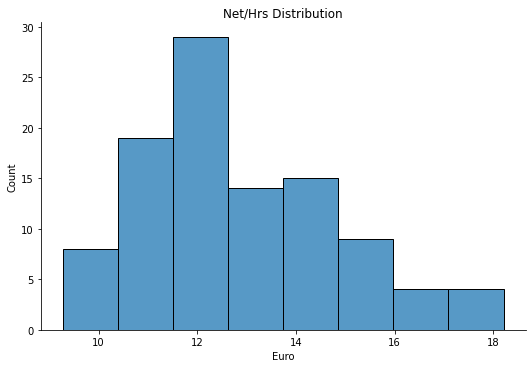

In [13]:
def distr(x,z):
    g=sns.displot(x=x,data=df, aspect=1.5)
    g.set_axis_labels("Euro")
    plt.title(z)
    plt.show()

    plt.show()
    
distr('nethrs','Net/Hrs Distribution')

In [14]:
df.nethrs.mean()

12.91166666666667

The Net/Hrs distribution span from 9.28€/h to 18,21€/h and it is centered around 13€/h

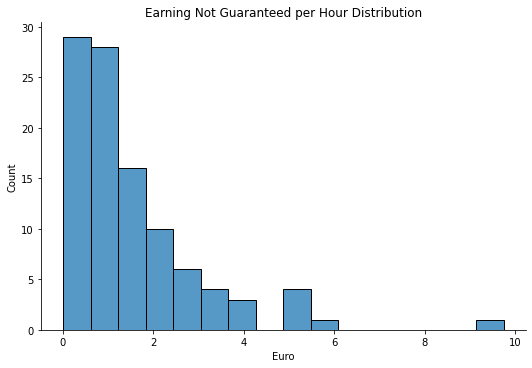

In [15]:
distr('more','Earning Not Guaranteed per Hour Distribution')

In [16]:
df.more.mean()

1.476879084967321

The 'More' distribution is a exponential distribution span from 0€/h to 9.74€/h.
On avarage I was working 1.47€/h above the minimum earning.

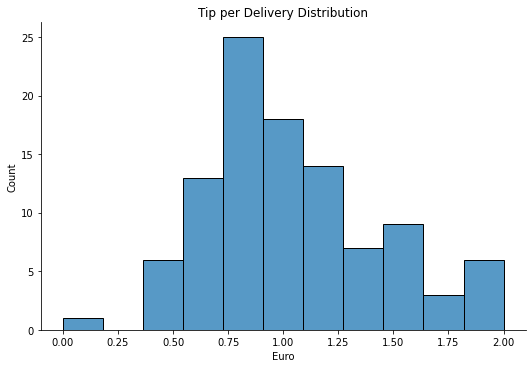

In [17]:
distr('tipdel','Tip per Delivery Distribution')

The normal distribution of the tip per delivery span to 0€ to 2.0€ and it is centered around 1€.

In [20]:
df.tipdel.mean()

1.0429411764705883

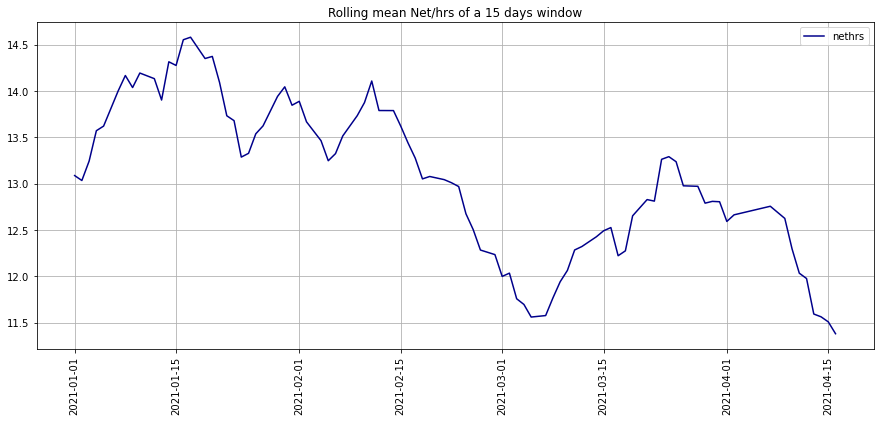

In [22]:
def rolmean(x,y,w,z):
    fig, ax = plt.subplots(figsize=(15,6)) 
    rol_mean=y.rolling(w).mean()
    ax.plot(x,rol_mean, color='darkblue',label=y.name)
    plt.title(z)
    plt.xticks(rotation=90)
    plt.legend()
    plt.grid()
    
rolmean(df.date,df.nethrs,15,'Rolling mean Net/hrs of a 15 days window')

In order to have a more robust indicator of the net/hrs through the days, I used the rolling mean of of 15 days. Every value is the average of the previous 14 working days.
* The rolling mean of Net/Hrs span from 14.5€/h to 11.5€/h
* The value decrease continuosly from February 10 to March 10, followed by an increasing until March 22, is due to what?

We are going to see again this data visualization in relation with meterological condition


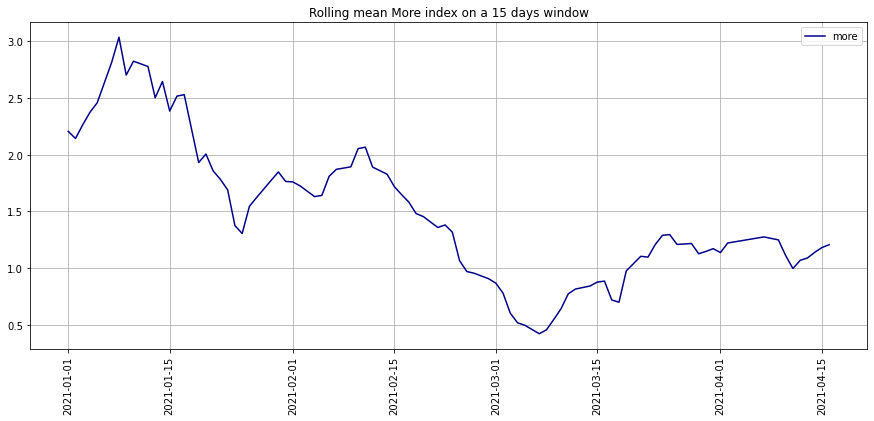

In [23]:
rolmean(df.date,df.more,15,'Rolling mean More index on a 15 days window')

* The rolling mean of 'More' index span from 3€/h to 0.5€/h
* Even in this graph there's a decreasing of the value by it's highest point from January 7 until January 22 where the values seem to stabilize on 2 €/h.  The value of 'More' index then descend again until its minimum on the first days of March, afterwards  it stabilizes below 1.5 €/h

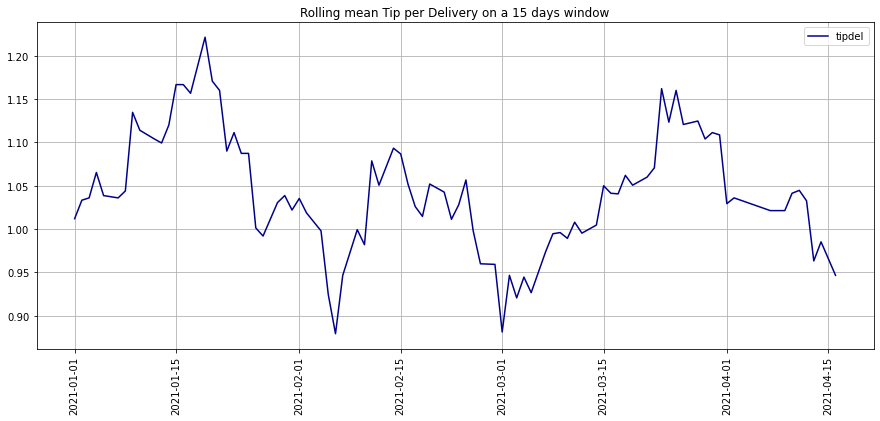

In [24]:
rolmean(df.date,df.tipdel,15,'Rolling mean Tip per Delivery on a 15 days window')

* The rolling mean of Tip per Delivery it's more complex and span from a more limited interval of 1.2€/del to 0.9€/del.
* Three different peaks can be identified on January 19, February 15 and March 22, it's difficult to predict what their cause is.

## Cumulative Avarage during time of:
### Net/Hrs, More, Tipdel

In [25]:
nethrs_inc=df['net'].cumsum()/df['hrs'].cumsum() #cumulative sum
more_inc=(df['earnings'].cumsum()-df['hrs'].cumsum()*10) /df['hrs'].cumsum()
tipdel_inc=tips.cumsum()/df['deliveries'].cumsum()

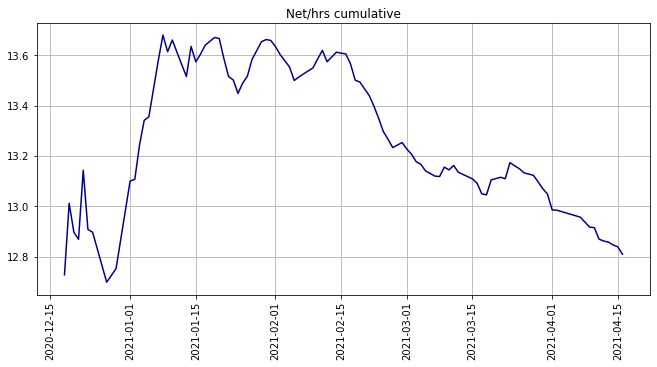

In [26]:
def plotti(x,y,z):
    fig, ax = plt.subplots(figsize=(11,5)) 
    ax.plot(x,y, color='darkblue')
    plt.title(z)
    plt.xticks(rotation=90)
    plt.grid()
plotti(df.date[5:], nethrs_inc[5:],'Net/hrs cumulative')

Each point of this graph is the average of the values observed up to that point:
* It is interesting to observe that both for Net/hrs, 'More' and 'tip_per_delivery', values are decreasing and slowing stabilizing

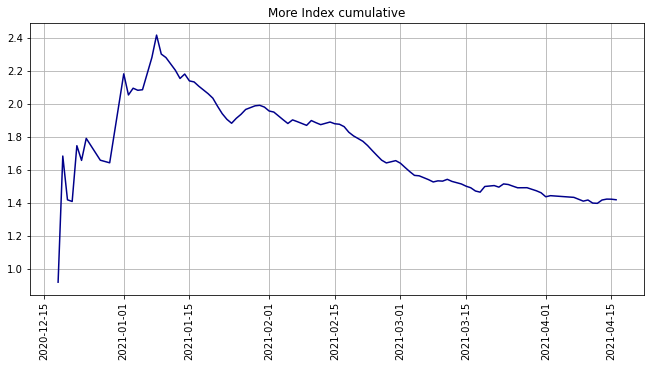

In [27]:
plotti(df.date[5:], more_inc[5:],'More Index cumulative')

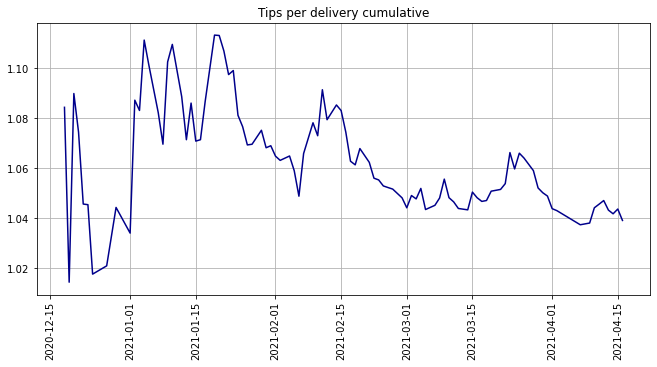

In [28]:
plotti(df.date[5:], tipdel_inc[5:],'Tips per delivery cumulative')

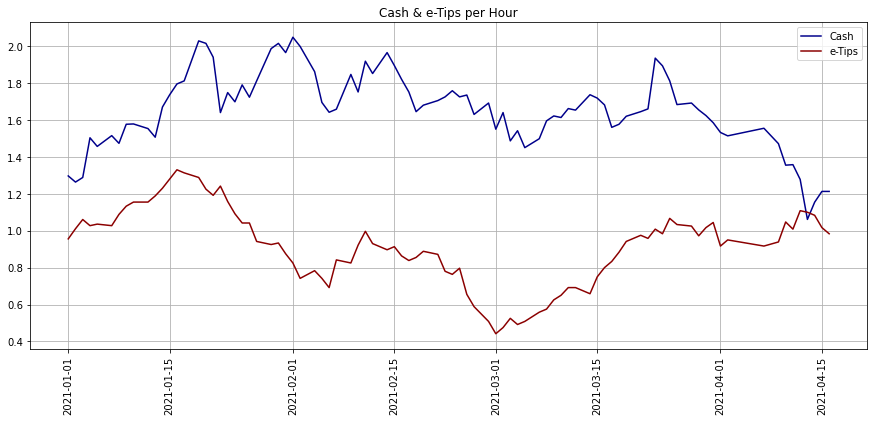

In [29]:
def tipsratio(x,y,y1,w,z):
    fig, ax = plt.subplots(figsize=(15,6)) 
    rol_mean=y.rolling(w).mean()
    rol_mean1=y1.rolling(w).mean()
    ax.plot(x,rol_mean, color='darkblue',label='Cash')
    ax.plot(x,rol_mean1, color='darkred',label='e-Tips')
    plt.title(z)
    plt.xticks(rotation=90)
    plt.legend()
    plt.grid()
tipsratio(df.date ,df.cash/df.hrs,df.etips/df.hrs,15,'Cash & e-Tips per Hour')

array([<AxesSubplot:ylabel='0'>], dtype=object)

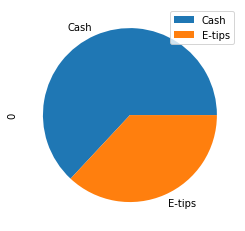

In [30]:
(pd.DataFrame([df.cash.cumsum()[126], df.etips.cumsum()[126]],
              index=['Cash','E-tips'])).plot(kind='pie',subplots=True)

* We see that the distribution of tips through 'cash' is on most of the cases always greater than the one via application (e-Tips).

* In particular '**Cash**' is **67%** of the total Tips while '**e-Tips**' are only **33%**.

In [31]:
def plottimonthly(y):
    diz={12:'December',1:'January',2:'February',3:'March',4:'April'}
    for el in df.date.dt.month.unique():
        fig, ax = plt.subplots(figsize=(6,4)) 
        ax.plot(df.date[df.date.dt.month==el],y[df.date.dt.month==el], color='darkblue')
        plt.title(diz[el])
        plt.xticks(rotation=90)
        plt.grid()
#plottimonthly(df.nethrs)

## Countplot and Boxplot over Days of the Week

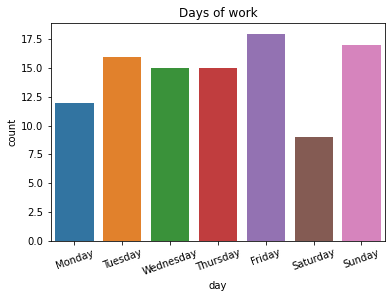

In [32]:
my_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday','Friday','Saturday','Sunday']
g=sns.countplot(x='day', data=df, order=my_order)
g.set_xticklabels(labels=my_order,rotation=20)
plt.title('Days of work')
plt.show()

I worked almost evenly on all days of the week with the exception of Saturday when I worked almost half as much in comparison.
In the following analysis I've removed Saturday for its reduced data size.

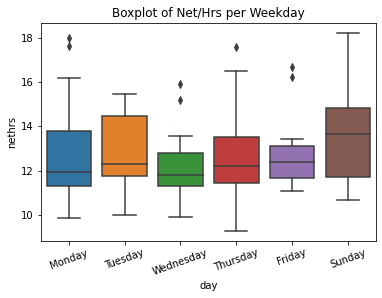

In [42]:
df_filt = df.groupby('day').filter(lambda g: len(g) >10)#it should have more than 10 counts
g=sns.boxplot(x='day', y='nethrs', data=df_filt)
g.set_xticklabels(labels=my_order,rotation=20)
plt.title('Boxplot of Net/Hrs per Weekday')
plt.show() 


In [43]:
df_filt.groupby('day')['nethrs'].median().sort_values()

day
Wednesday    11.81
Friday       11.92
Thursday     12.19
Sunday       12.31
Monday       12.40
Tuesday      13.67
Name: nethrs, dtype: float64

It seems that there are no important differences between the days of the week except for Tuesday, however the sample size is small and statistically irrelevant and can't lead to any conclusion.

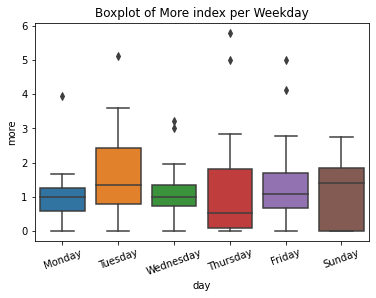

In [44]:
g=sns.boxplot(x='day', y='more', data=df[df.more<8], order=my_order)
g.set_xticklabels(labels=my_order,rotation=20)
plt.title('Boxplot of More index per Weekday')
plt.show() 

In [45]:
df_filt.groupby('day')['more'].median().sort_values()

day
Thursday     0.517500
Monday       0.993333
Wednesday    1.000000
Friday       1.088750
Tuesday      1.327500
Sunday       1.407500
Name: more, dtype: float64

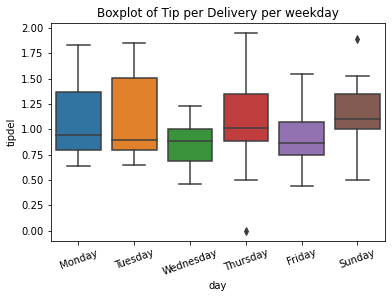

In [46]:
g=sns.boxplot(x='day', y='tipdel', data=df, order=my_order)
g.set_xticklabels(labels=my_order,rotation=20)
plt.title('Boxplot of Tip per Delivery per weekday')
plt.show()

In [48]:
df_filt.groupby('day')['tipdel'].median().sort_values()

day
Friday       0.870
Wednesday    0.890
Tuesday      0.895
Monday       0.940
Thursday     1.010
Sunday       1.100
Name: tipdel, dtype: float64

It is interesting to note that the biggest difference found is between Sunday and Friday, both weekend days, however it is still difficult to say if it is statistically relevant.

In [49]:
df.to_csv(r'/home/nico/Desktop/Stats/Work/Work_analysis.csv', index = False) #export data for weather-analysis

OSError: Cannot save file into a non-existent directory: '/home/nico/Desktop/Stats/Work'